<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<div id="subject">
<CENTER>
<CENTER>
</br>
<br>
<font size="5"></br> ELU 502 Deep Learning final project:</font></br></div>
<CENTER>
</br>
<CENTER>
<font size="5"></br>Learning Deep Features for Discriminative Localization</font></br></div>
</CENTER>

<CENTER>
<font size="3"></br>9th of December 2018</font></br></div>
</CENTER>

<br>
<CENTER>
<span size="5">Gonzalo QUINTANA (gonzalo-inaki.quintana@imt-atlantique.net)</span>
</CENTER>
<CENTER>
<span size="5">Claude KADJO MAMI (c18kadjo@telecom-bretagne.eu)</span>
</CENTER>

</div>

## Introduction

The following work is based in the article Learning Deep Features for Discrimination Localization. Previous works showed that Convolutional units of CNNs actually behave as object detectors (despite no supervision on the location of the object).
This work is devoted to the analisis of activation maps in networks used for image classification. A class activation map is an image of the same size of the input image which shows the most important areas of the image for being classified into class $c$. We analize the activation maps of two images from the 'Imagenet' database.  We first analize the activation maps for the top three classes of those images (the three classes that have higher probability of being the real class). After that, we add some gaussian white noise to all pixels in the images and show how the activation maps change (and see if there is a different classification result). At the end, we set to zero the most important images areas (obtained through the activation maps) and see if there is a change in the classification result.

## Class Activation Maps

A Class Activation Map for a particular category indicates the discriminative image regions used by the CNN to identify that category. In other words, it shows which are the regions that were considered the most important for classifying the image in that class. In the following image, for example, we can see that the most important features of the images on the left to be classified into the category "Brushing Teeth" are, not surprisingly, the toothbrushs. In the other hand, the dominant features for classifying that image into the category "cutting trees" were the saw and the protections on the mans' head.


![image.png](Téléchargements/brushing.png)


In this work, we will use the VGG16 network pretrained with the image set 'Imagenet' to analize the activation maps of two bird images from that image set. To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations.

## Network Architecture

The network architecture considered is the one shown in the following picture. That is, the classical scheme for image classification, reeplacing the max pooling layer after the last convolutional layer by an average pooling layer. The reason for doing this is that Global Average Pooling (GAP) outperforms Global Max Pooling (GMP) in localization, as it takes into consideration all discriminative regions of an image and not just the most discriminative of all regions.

![image.png](Téléchargements/Architecture.png)

Mathematically, each element of an activation map $M_c$ can be defined as

\begin{equation}
M_c(x,y)=\sum_{k}{w_k^c f_k(x,y)}
\end{equation}

where $f_k(x,y)$ represents the activation of unit $k$ in the last convolutional layer at a spatial location $(x,y)$ (this is usually called the feature map of unit $k$) and $w_k^c$ is the weight corresponding to class $c$ for $k$ . In other words, the activation map for class $c$ is a linear combination of all feature maps (that are specialized in detecting a particular feature of the image). The $w_k^c$ vector gives us an idea of the importance of each feature $k$ to that class $c$ .With this definition, the input to the softmax layer can be calculated as

\begin{equation}
S_c = \sum_{x,y} M_c(x,y)
\end{equation}

In order to generate those activations maps, we used the Keras function visualize_cam, which . Even though our VGG16 network has a max pooling layer after the last convolutional layer (instead of having an average pooling layer), by reading the code of this function we realized that there was no need to replace this GMP layer for a GAP layer. In order to obtain the feature maps, this function identifies the last convolutional layer, takes its outputs (one for each filter) and calculates a global average pooling (GAP) with it. After that, it makes a linear combination with all the feature maps to obtain the class activation map for the desired class.

## How does this function calculates the Class Activation Maps?

In the following figure we show a scheme that explains how this Keras method calculates the class activation maps.

![image.png](Téléchargements/backprop.png)

First of all, the gradients of the scores for class $c$, $y^c$ with respect to feature maps $f_k(x,y)$ of the last convolutional layer are calculated

\begin{equation}
\frac{\partial{y^c}}{\partial{f_k(x,y)}}
\end{equation}

These gradients flowing back are gobal averaged-pooled to obtain the neuron importance weights $\alpha_k$, which represents the importance of feature map $k$ for a target class $c$

\begin{equation}
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial{y^c}}{\partial{f_k(x,y)}}
\end{equation}

Finally a weighted combination of the forward activation feature maps followed by a ReLu is performed. The reason of applying ReLu is because we are only interested in the features that have a positive influence on the class of interest (pixels whose intensity should be increased in order to increase $y^c$).

\begin{equation}
M_C (x,y) =  \sum_k \alpha_k^c f_k(x,y)
\end{equation}

This explanation was construcetd by reading the function's code and the article "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization", both available in the Keras webpage. The "backprop modifier" parameter in this method allows the user to change the way information is backpropated; in this work we decided not to use any backrpopagation modifiers.

In [1]:
import keras
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


ResourceExhaustedError: OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block4_conv1/bias/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_conv1/bias, block4_conv1/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'block4_conv1/bias/Assign', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-07b7706bf3a1>", line 7, in <module>
    model = VGG16(weights='imagenet', include_top=True)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/applications/__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/applications/vgg16.py", line 11, in VGG16
    return vgg16.VGG16(*args, **kwargs)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras_applications/vgg16.py", line 149, in VGG16
    name='block4_conv1')(x)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/layers/convolutional.py", line 147, in build
    constraint=self.bias_constraint)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 387, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/opt/campux/virtualenv/deeplearning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block4_conv1/bias/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_conv1/bias, block4_conv1/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
model.summary()

We will work and perform tests with these two images : 

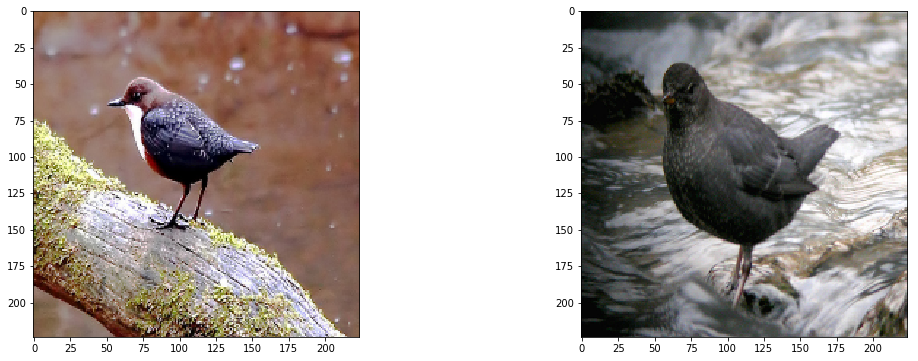

In [6]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('images/ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('images/ouzel2.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

We now classify these two images with our VGG network. We obtain the top three classes for the two images.

In [13]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


preds = model.predict(x)
class1=np.argmax(preds)

print('Image 1')
print('Predicted:', decode_predictions(preds,3))

x = image.img_to_array(img2)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


preds = model.predict(x)
class1=np.argmax(preds)

print('Image 2')
print('Predicted:', decode_predictions(preds,3))

Image 1
Predicted: [[('n01601694', 'water_ouzel', 15.717963), ('n12267677', 'acorn', 8.936059), ('n02177972', 'weevil', 8.626398)]]
Image 2
Predicted: [[('n01601694', 'water_ouzel', 16.772135), ('n01534433', 'junco', 12.791119), ('n02018207', 'American_coot', 12.63288)]]


# Activation Maps

We show the activation maps of the images. With this, we can recognize the most important activation areas for classifying each image.

<Figure size 1296x432 with 0 Axes>

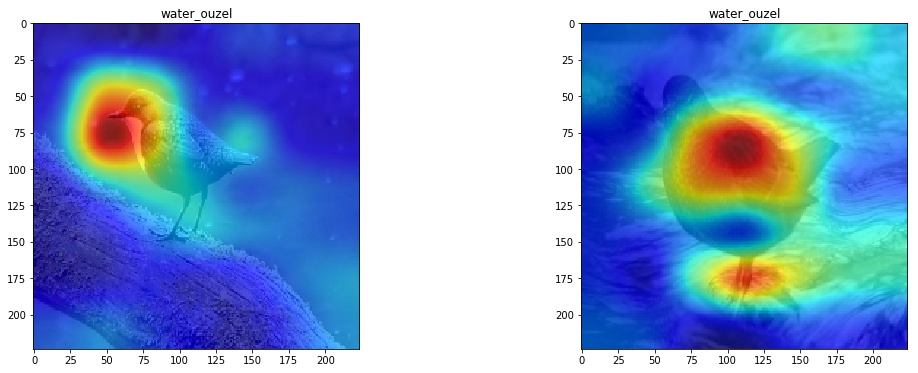

In [8]:
from vis.visualization import visualize_cam, overlay
import matplotlib.cm as cm
import numpy as np

plt.figure()
f, ax = plt.subplots(1, 2)

for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax[i].imshow(overlay(grads, img,0.7))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)

    if (i==0): ax[i].set_title(decode_predictions(preds,1)[0][0][1])
    if (i==1): ax[i].set_title(decode_predictions(preds,1)[0][0][1])

Now, we show the activation maps of the three top classes for the first image

<Figure size 1296x432 with 0 Axes>

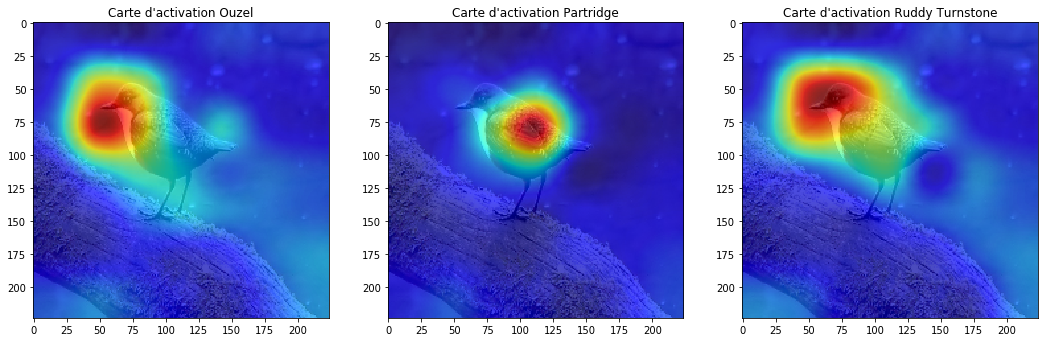

In [9]:
from vis.visualization import visualize_cam, overlay
import matplotlib.cm as cm
import numpy as np

plt.figure()
f, ax = plt.subplots(1, 3)

for i, img in enumerate([img1]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads1 = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier=None) 
    # 82 is the imagenet index corresponding to `partridge`
    grads2 = visualize_cam(model, layer_idx, filter_indices=82,
                          seed_input=img, backprop_modifier=None)  
    # 139 is the imagenet index corresponding to `ruddy turnstone`
    grads3 = visualize_cam(model, layer_idx, filter_indices=139,
                          seed_input=img, backprop_modifier=None)
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    ax[i].imshow(overlay(grads1, img,0.7))
    ax[i+1].imshow(overlay(grads2, img,0.7))
    ax[i+2].imshow(overlay(grads3, img,0.7))


    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    ax[i].set_title("Carte d'activation Ouzel")
    ax[i+1].set_title("Carte d'activation Partridge")
    ax[i+2].set_title("Carte d'activation Ruddy Turnstone")

## Perturbation of the images with White Gaussian Noise

We add gaussian noise to all pixels of the image. By changing the variable noise_factor, we can variate the amount of noise we add. If noise factor is 0, we add no noise. If we add a little noise, the classification result does not change. We observe that if noise_factor is 1.1 we still have good classification in the two images. However, if noise factor is 1.2, the first image is well classified but the second image is classified in the wrong class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: water_ouzel
Predicted: electric_ray


<Figure size 1296x432 with 0 Axes>

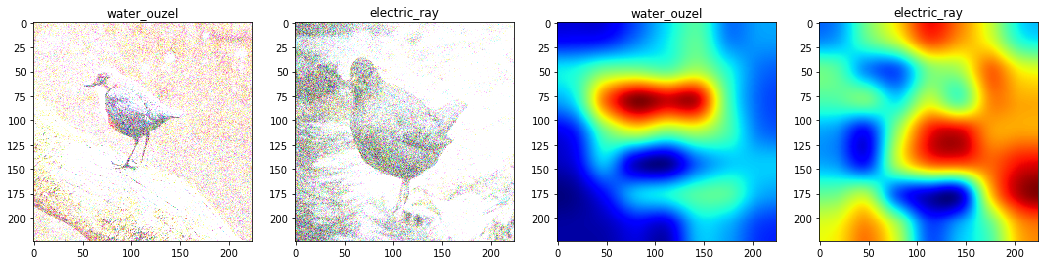

In [10]:
noise_factor=1.2 #1.2 est le valeur limite pour image2

img1 = utils.load_img('images/ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('images/ouzel2.jpg', target_size=(224, 224))

plt.figure()
f, ax = plt.subplots(1, 4)

for i, img in enumerate([img1, img2]):    

    img=img+(noise_factor*np.random.normal(loc=128,scale=40,size=(224,224,3)))
    img = img/255
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    #ax[i].imshow(overlay(grads, img*255,0.5))
    ax[i].imshow(img)
    ax[i+2].imshow(grads)


    x = image.img_to_array(img*255)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    if (i==0): ax[i].set_title(decode_predictions(preds,1)[0][0][1])
    if (i==1): ax[i].set_title(decode_predictions(preds,1)[0][0][1])
        
    if (i==0): ax[i+2].set_title(decode_predictions(preds,1)[0][0][1])
    if (i==1): ax[i+2].set_title(decode_predictions(preds,1)[0][0][1])

    print('Predicted:', decode_predictions(preds,1)[0][0][1])

## Elilmination of image areas

Now, we set to zero some great areas of the image and we observe the classification result

<Figure size 1296x432 with 0 Axes>

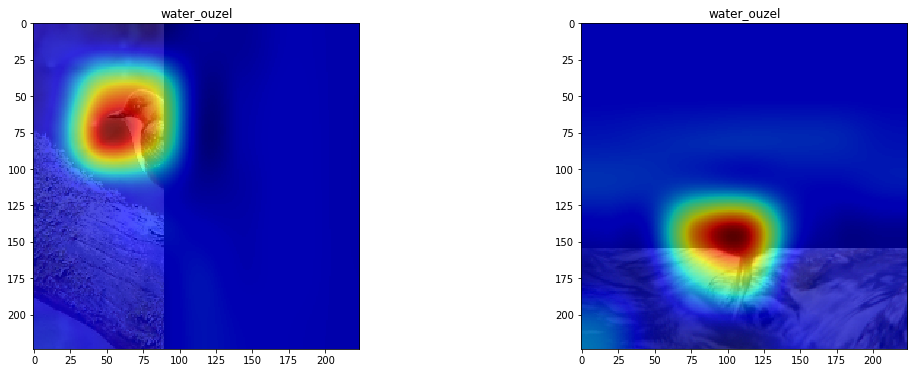

In [11]:
from vis.visualization import visualize_cam, overlay
import matplotlib.cm as cm
import numpy as np

img1 = utils.load_img('images/ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('images/ouzel2.jpg', target_size=(224, 224))


plt.figure()
f, ax = plt.subplots(1, 2)
#plt.suptitle("vanilla")
for i, img in enumerate([img1,img2]):    
    if (i==0):img[0:300,90:]=0
    if (i==1):img[0:155,:]=0
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    #ax[i].imshow(overlay(grads, img,0.7))
   
    ax[i].imshow(overlay(grads, img,0.7))

    #ax[i].suptitle("hola")

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    if (i==0): ax[i].set_title(decode_predictions(preds,1)[0][0][1])
    if (i==1): ax[i].set_title(decode_predictions(preds,1)[0][0][1])

    #print('Predicted:', decode_predictions(preds,1)[0][0][1])

Here we can see that when non important areas are eliminated, the classification result is unmodified.

<Figure size 1296x432 with 0 Axes>

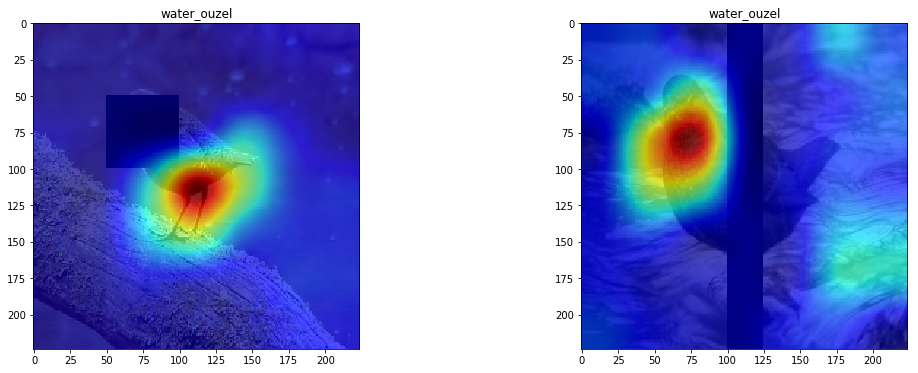

In [12]:
from vis.visualization import visualize_cam, overlay
import matplotlib.cm as cm
import numpy as np

img1 = utils.load_img('images/ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('images/ouzel2.jpg', target_size=(224, 224))

#for modifier in [None, 'guided', 'relu']:
plt.figure()
f, ax = plt.subplots(1, 2)

for i, img in enumerate([img1,img2]):    
    if (i==0):
        img[50:100,50:100]=0
        #img[100:110,60:75]=0
    if (i==1):img[:,100:125]=0
    #img[100:130,100:130]=0
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax[i].imshow(overlay(grads, img,0.7))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    if (i==0): ax[i].set_title(decode_predictions(preds,1)[0][0][1])
    if (i==1): ax[i].set_title(decode_predictions(preds,1)[0][0][1])

    #print('Predicted:', decode_predictions(preds,1)[0][0][1])


What we can see here is that when we eliminate areas of the image that were important, the network incredibly find new areas to recognize the bird and classify the image correctly.

## Conclusion 

To sum up, in this work we have calculated the activation maps of two imagenet pictures, classified with the VGG16 networks. We have explained the mathematical formulation of activation maps and understood how this maps are obtained with the Keras function "cam_visualization", by reading related articles and the function's code. We have been able to perform several tests, like addying white noise to the images and watching the activation maps get deformed.
Finally, by setting to zero the most relevant image's areas for classification, we've seen how the network still managed to classify correctly the images. As a consequence, activation maps changed.